<a href="https://colab.research.google.com/github/Gruppe3VDL/Gruppe3VDLws2019/blob/master/exercise3/task1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Gruppe3VDL/Gruppe3VDLws2019/blob/master/exercise3/task1_2.ipynb)

# Semantic Segmentation

## Step 1:
Download and extract the bags dataset
https://drive.google.com/file/d/1P4bdP6nSUOqQLhGXvZ1z4z3hNncJFrCs

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#########################################################################
## Navigate to the exercise directory.                                 ##
##                                                                     ##
## IMPORTANT:                                                          ##
## Either change the path below to the exercise folder in your drive   ##
## or put the folder at same path in your drive (recommended).         ##
#########################################################################

%cd 'drive/My Drive/TUK/Very Deep Learning/Exercises/exercise3/'

/content/drive/My Drive/TUK/Very Deep Learning/Exercises/exercise3


In [3]:
#########################################################################
## Extract bags dataset.                                               ##
#########################################################################

import os
import zipfile


if not os.path.exists('data/bags_data'):
  print("Extracting dataset...")
  with zipfile.ZipFile("data/bags_data.zip","r") as zip_ref:
      zip_ref.extractall("data/")
  print("Done.")
else:
  print("Dataset already extracted.")

Dataset already extracted.


In [4]:
# Define dataset paths
root = 'data/bags_data/'
%ls $root

images = root + 'JPEGImages/'
masks = root + 'segmentation_mask/'
imagesets = root + 'imagesets/'

imagesets/  JPEGImages/  segmentation_mask/


## Step 2:
Write a ```pytorch``` [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class which can iterate over the dataset. (Hint: Get inspiration from the [```pytorch``` tutorials](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html))

In [0]:
import numpy as np
import torch

from PIL import Image
from torch.utils.data import Dataset


class BagsDataset(Dataset):
    """Bags dataset."""

    def __init__(self, root_dir, masks_dir, idx, transform=None):
        """
        Args:
            root_dir (string): Directory with the images.
            masks_dir (string): Directory with segmentation masks.
            idx (array): Ids of images to include in this dataset.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.masks_dir = masks_dir
        self.idx = idx
        self.transform = transform

    def __len__(self):
        return self.idx.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, str(int(self.idx[idx])) + ".jpg")
        image = Image.open(img_name)

        mask_name = os.path.join(self.masks_dir, str(int(self.idx[idx])) + ".png")
        mask = Image.open(mask_name)

        sample = {'image': image, 'mask': mask}

        if self.transform:
            sample['image'] = self.transform(sample['image'])
            sample['mask'] = self.transform(sample['mask'])

        return sample

In [6]:
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, utils


print("Loading training set...")
train_idx = np.loadtxt(imagesets + 'train.txt')
traindata = BagsDataset(images, masks, train_idx,
                        transforms.Compose([
                            transforms.Resize((224,224)),
                            transforms.ToTensor()
                        ]))
print(len(traindata), "images in train set.\n")

print("Loading validation set...")
val_idx = np.loadtxt(imagesets + 'val.txt')
valdata = BagsDataset(images, masks, val_idx,
                      transforms.Compose([
                          transforms.Resize((224,224)),
                          transforms.ToTensor()
                      ]))
print(len(valdata), "images in validation set.\n")

Loading training set...
427 images in train set.

Loading validation set...
107 images in validation set.



Creating data loaders...
Show sample batch from created datasets...


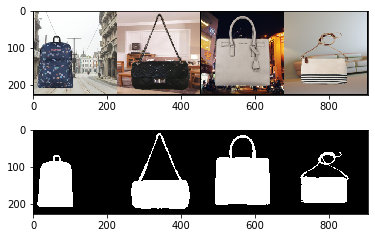

In [7]:
from torchvision.utils import make_grid


def convert_img(im, mask=False):
  im = im.numpy()
  im = np.transpose(im, (1, 2, 0))
  if mask:
    im = (im / np.max(im))
  return im

# Create dataloaders for train and validation sets
print("Creating data loaders...")
trainloader = DataLoader(traindata, batch_size=4, shuffle=True, num_workers=4)
valloader = DataLoader(valdata, batch_size=4, shuffle=True, num_workers=4)

print("Show sample batch from created datasets...")
batch = iter(trainloader).next()
images = batch['image']
masks = batch['mask']
# masked_imgs = images & masks

ax = plt.subplot(2, 1, 1)
plt.imshow(convert_img(make_grid(images)))

ax = plt.subplot(2, 1, 2)
plt.imshow(convert_img(make_grid(masks), mask=True))
# plt.imshow(convert_img(make_grid(masked_imgs)))

## Step 3:
Train a fully-convolutional network on the training dataset.
Hint: You can either define your own FCN or use an already implemented model (e.g. https://github.com/wkentaro/pytorch-fcn)

## Step 4:
Report the mean IoU score after each epoch for both training dataset and validation dataset

## Step 5:
Visualize your network output on one image of the validation set